In [57]:
# Importing necessary libraries
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout

In [58]:
# Loading the training and testing data
train = pd.read_csv('F:\Yash\Dataset_SSOC\written_name_train_v2.csv')
valid = pd.read_csv('F:\Yash\Dataset_SSOC\written_name_validation_v2.csv')

TypeError: Image data of dtype object cannot be converted to float

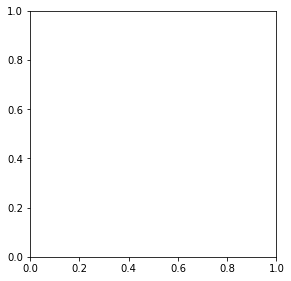

In [81]:
# Viewing the data
plt.figure(figsize=(15, 10))

# To view first 6 images
for i in range(6):
    # plt.subplot(nrows, ncols, index)
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'F:\Yash\Dataset_SSOC\train_v2\train'+train.loc[i, 'FILENAME']
    # cv2.imread(path=img_dir, flag=specifies the way in which image should be read)
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    # cv2.imread(X=data of the image, colormap instance)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')
# Adjusts the subplot layout parameters
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [60]:
# Cleaning the data by checking for null values
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [61]:
# Dropping the null values from the training and testing data
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

TypeError: Image data of dtype object cannot be converted to float

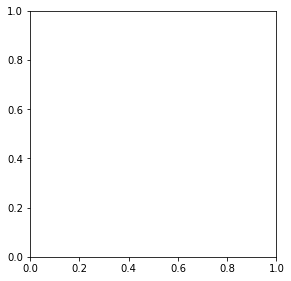

In [62]:
# Removing the data with the label 'UNREADABLE'
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
# resets the index of the DataFrame, and uses the default one instead
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'F:\Yash\Dataset_SSOC\train_v2\train'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [63]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [64]:
# converting some lowercase labels to uppercase to maintain uniformity
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [65]:
# resetting the index to maintain uniform leveling
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

In [66]:
def preprocess(img):
    (h, w) = img.shape
    # blank white image
    final_img = np.ones([64, 256])*255 
    
    # cropping the image if the width and height are greater than 
    # 256 and 64 respectively
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    # rotating the image clockwise to bring the image shape to (x,y)
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [ ]:
# training the model 30000 images and the validating it on 3000 images
train_size = 30000
valid_size= 3000

In [68]:
# training
train_x = []

for i in range(train_size):
    img_dir = 'F:\Yash\Dataset_SSOC\train_v2\train'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

AttributeError: 'NoneType' object has no attribute 'shape'

In [69]:
# validating
valid_x = []

for i in range(valid_size):
    img_dir = 'F:\Yash\Dataset_SSOC\validation_v2\validation'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
# .reshape(a: array_like = -1(we want numpy to figure out as the dimensions are unknown))
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [70]:
# labels are converted to numbers representing each character
# labels are then prepared for Connectionist Temporal Classification Loss (CTC Loss)
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
# max length of input labels
max_str_len = 24 
# +1 for ctc pseudo blank
num_of_characters = len(alphabets) + 1 
# max length of predicted labels
num_of_timestamps = 64 


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [71]:
name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [ 9  4  1  0 18 19  8 13]


In [72]:
# train_y contains the true labels converted to numbers and padded with -1. 
# The length of each label is equal to max_str_len.
train_y = np.ones([train_size, max_str_len]) * -1
# train_label_len contains the length of each true label (without padding)
train_label_len = np.zeros([train_size, 1])
# train_input_len contains the length of each predicted label. 
# The length of all the predicted labels is constant i.e number of timestamps - 2.
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
# train_output is a dummy output for ctc loss.
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])    

In [73]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])   

In [74]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


In [75]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization_3 (Batc  (None, 256, 64, 32)      128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                           

In [76]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [77]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [79]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=60, batch_size=128)

Epoch 1/60


ValueError: in user code:

    File "f:\Anaconda\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "f:\Anaconda\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "f:\Anaconda\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "f:\Anaconda\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "f:\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "f:\Anaconda\lib\site-packages\keras\engine\input_spec.py", line 200, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_3" expects 4 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 24) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 1) dtype=float32>]


In [82]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

KeyError: 'pop from an empty set'

In [83]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

NameError: name 'prediction' is not defined

In [84]:
test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/handwriting-recognition/written_name_test_v2.csv'